In [ ]:
!python m.py


Exploring training data...
Loading data from /tscc/nfs/home/bax001/scratch/CSE_251B/data/train.npz...
Dataset shape: (10000, 50, 110, 6)
History data shape: (10000, 50, 50, 6)
Future data shape: (10000, 60, 2)

=== Basic Statistics and Padding Analysis ===
Total trajectory entries: 25000000
Padded entries: 13315005 (53.26%)
Total scenes: 10000
Average valid agents per scene: 31.65
Max valid agents in a scene: 50
Min valid agents in a scene: 1

Padding analysis by agent index:
  Agent 0: 100.00% valid positions
  Agent 1: 99.99% valid positions
  Agent 2: 99.06% valid positions
  Agent 3: 97.26% valid positions
  Agent 4: 95.17% valid positions
  Last agent (49): 11.79% valid positions

INSIGHT - Padding Analysis:
- 53.3% of trajectory entries are padding zeros
- The first agent (index 0) has 100.0% valid positions
- Valid agent percentage decreases with agent index, suggesting agents are ordered by importance
- Model Implication: Consider focusing on the first ~20 agents for most scene

In [2]:
import os
current_dir = os.getcwd()
if "tscc" in current_dir:
    os.chdir("/tscc/projects/ps-lalexandrov/bax001/CSE_251B")

In [35]:
import platform
platform.node()


'tscc-gpu-14-25'

In [33]:
 os.chdir("/Users/lilian/Documents/UCSD/CSE_251B_course/CSE_251B/banghua-local/")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lilian/Documents/UCSD/CSE_251B_course/CSE_251B/banghua-local/'

In [19]:
import os
current_dir = os.getcwd()
if "tscc" in current_dir:
    os.chdir("/tscc/projects/ps-lalexandrov/bax001/CSE_251B")

In [37]:
!pwd
!ls ./data_utils/


/tscc/projects/ps-lalexandrov/bax001/CSE_251B
data_explore.py  data_utils.py	feature_engineering.py	__pycache__


In [39]:
import data_utils.data_utils as dud
print(dir(dud))


['Dataset', 'ImprovedTrajectoryDataset', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'np', 'torch']


In [3]:
from data_utils.data_utils import TrajectoryDataset


In [22]:
import sys
sys.path.append('/tscc/projects/ps-lalexandrov/bax001/CSE_251B')


Using device: cuda

Training with MSE loss
[MSE] Epoch 1: Train=1.7950, Val=0.5542
[MSE] Epoch 2: Train=0.4621, Val=0.3849
[MSE] Epoch 3: Train=0.3509, Val=0.3098
[MSE] Epoch 4: Train=0.2981, Val=0.2666
[MSE] Epoch 5: Train=0.2680, Val=0.2454
[MSE] Epoch 6: Train=0.2579, Val=0.2380
[MSE] Epoch 7: Train=0.2450, Val=0.2384
[MSE] Epoch 8: Train=0.2457, Val=0.2307
[MSE] Epoch 9: Train=0.2352, Val=0.2280
[MSE] Epoch 10: Train=0.2275, Val=0.2044
[MSE] Epoch 11: Train=0.2259, Val=0.2134
[MSE] Epoch 12: Train=0.2272, Val=0.2088
[MSE] Epoch 13: Train=0.2223, Val=0.2040
[MSE] Epoch 14: Train=0.2177, Val=0.1988
[MSE] Epoch 15: Train=0.2203, Val=0.2122
[MSE] Epoch 16: Train=0.2160, Val=0.2130
[MSE] Epoch 17: Train=0.2144, Val=0.2259
[MSE] Epoch 18: Train=0.2160, Val=0.2082
[SmoothL1] Epoch 1: Train=0.4325, Val=0.1830
[SmoothL1] Epoch 2: Train=0.1593, Val=0.1370
[SmoothL1] Epoch 3: Train=0.1266, Val=0.1179
[SmoothL1] Epoch 4: Train=0.1093, Val=0.1020
[SmoothL1] Epoch 5: Train=0.1050, Val=0.0951
[Sm

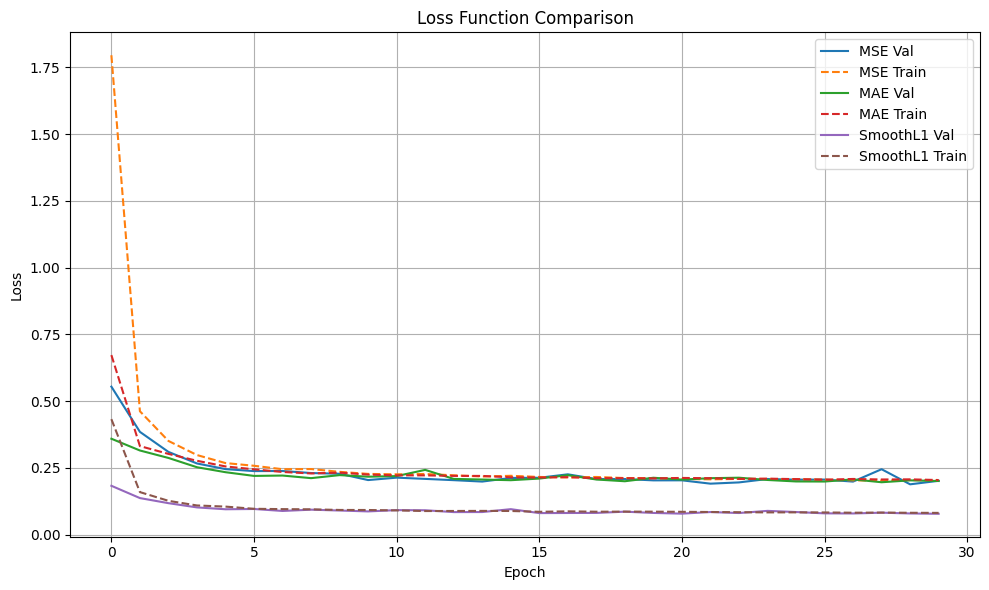

In [4]:
# loss_function_comparison.ipynb

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from data_utils.data_utils import TrajectoryDataset
from models.model import GRUModel  # or LSTMModel, TransformerModel

# Set seed and device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==== Load Data ====
train_path = '/tscc/nfs/home/bax001/scratch/CSE_251B/data/train.npz'
scale = 7.0
batch_size = 64

full_dataset = TrajectoryDataset(train_path, split='train', scale=scale, augment=True)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# ==== Helper: Train Loop ====
def run_training(loss_fn, loss_label, num_epochs=30):
    model = GRUModel(input_dim=6, hidden_dim=128, output_seq_len=60, output_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        for batch in train_loader:
            for key in batch:
                if isinstance(batch[key], torch.Tensor):
                    batch[key] = batch[key].to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = loss_fn(pred, batch['future'])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                for key in batch:
                    if isinstance(batch[key], torch.Tensor):
                        batch[key] = batch[key].to(device)
                pred = model(batch)
                loss = loss_fn(pred, batch['future'])
                total_val_loss += loss.item()
        val_losses.append(total_val_loss / len(val_loader))

        print(f"[{loss_label}] Epoch {epoch+1}: Train={train_losses[-1]:.4f}, Val={val_losses[-1]:.4f}")
    
    return train_losses, val_losses

# ==== Run Experiments with Different Losses ====
losses = {
    "MSE": nn.MSELoss(),
    "MAE": nn.L1Loss(),
    "SmoothL1": nn.SmoothL1Loss()
}

results = {}
for name, fn in losses.items():
    print(f"\nTraining with {name} loss")
    train_l, val_l = run_training(fn, name)
    results[name] = (train_l, val_l)

# ==== Plotting ====
plt.figure(figsize=(10, 6))
for name, (train_l, val_l) in results.items():
    plt.plot(val_l, label=f"{name} Val")
    plt.plot(train_l, linestyle="--", label=f"{name} Train")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Function Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_comparison.png")
plt.show()


In [6]:
# === Define Hybrid Loss ===
def hybrid_loss(pred, target, alpha):
    mse = nn.MSELoss()
    mae = nn.L1Loss()
    return alpha * mse(pred, target) + (1 - alpha) * mae(pred, target)

# === Define Loss Variants ===
losses = {
    "MSE": nn.MSELoss(),
    "MAE": nn.L1Loss(),
    "Hybrid_0.5": lambda pred, target: hybrid_loss(pred, target, alpha=0.5),
    "Hybrid_0.7": lambda pred, target: hybrid_loss(pred, target, alpha=0.7),
    "Hybrid_0.9": lambda pred, target: hybrid_loss(pred, target, alpha=0.9),
}

# === Track Results ===
results = {}
best_val_loss = float("inf")
best_name = None
best_model = None

for name, fn in losses.items():
    print(f"\nTraining with {name} loss")
    train_l, val_l = run_training(fn, name, num_epochs=10)
    results[name] = (train_l, val_l)

    # Select best by lowest final val loss
    if val_l[-1] < best_val_loss:
        best_val_loss = val_l[-1]
        best_name = name

print(f"\n✅ Best performing loss: {best_name} with final val loss = {best_val_loss:.4f}")



Training with MSE loss
[MSE] Epoch 1: Train=1.7773, Val=0.5397
[MSE] Epoch 2: Train=0.4511, Val=0.3633
[MSE] Epoch 3: Train=0.3386, Val=0.3082
[MSE] Epoch 4: Train=0.2947, Val=0.2691
[MSE] Epoch 5: Train=0.2719, Val=0.2461
[MSE] Epoch 6: Train=0.2521, Val=0.2636
[MSE] Epoch 7: Train=0.2501, Val=0.2599
[MSE] Epoch 8: Train=0.2371, Val=0.2175
[MSE] Epoch 9: Train=0.2366, Val=0.2309
[MSE] Epoch 10: Train=0.2312, Val=0.2274

Training with MAE loss
[MAE] Epoch 1: Train=0.6569, Val=0.3866
[MAE] Epoch 2: Train=0.3375, Val=0.3024
[MAE] Epoch 3: Train=0.3082, Val=0.3008
[MAE] Epoch 4: Train=0.2882, Val=0.2631
[MAE] Epoch 5: Train=0.2648, Val=0.2603
[MAE] Epoch 6: Train=0.2440, Val=0.2465
[MAE] Epoch 7: Train=0.2397, Val=0.2347
[MAE] Epoch 8: Train=0.2329, Val=0.2307
[MAE] Epoch 9: Train=0.2319, Val=0.2187
[MAE] Epoch 10: Train=0.2276, Val=0.2185

Training with Hybrid_0.5 loss
[Hybrid_0.5] Epoch 1: Train=1.1541, Val=0.4544
[Hybrid_0.5] Epoch 2: Train=0.3831, Val=0.3350
[Hybrid_0.5] Epoch 3: Tra

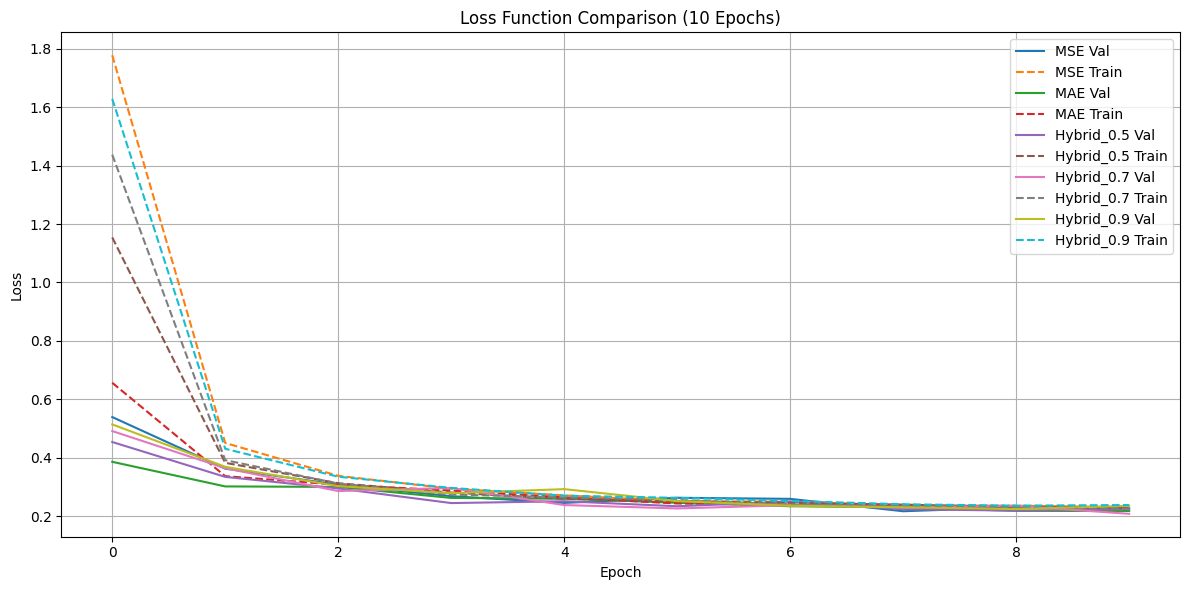

In [7]:
# === Plot Loss Curves ===
plt.figure(figsize=(12, 6))
for name, (train_l, val_l) in results.items():
    plt.plot(val_l, label=f"{name} Val")
    plt.plot(train_l, linestyle="--", label=f"{name} Train")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Function Comparison (10 Epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_comparison_hybrid_no_smoothL1.png")
plt.show()
